In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# For reproducibility
np.random.seed(42)


In [ ]:
# Load the CSV dataset
df = pd.read_csv('/content/Final_Dataset.csv')

# Display the first few rows and the column names to understand the structure.
print("Dataset Head:")
print(df.head())
print("\nColumns in dataset:")
print(df.columns)


Dataset Head:
   EMG_Channel_1  EMG_Channel_2  EMG_Channel_3  EMG_Channel_4  EMG_Channel_5  \
0            208            121            179             78             31   
1            214            126            175             78             32   
2            224            121            184             80             32   
3            156            105            169             69             31   
4            153            102            167             71             31   

   EMG_Channel_6  EMG_Channel_7  EMG_Channel_8    Timestamp (µs)      Gesture  
0             28             27             43  1740427874921460  Closed Fist  
1             28             27             45  1740427874936637  Closed Fist  
2             27             28             45  1740427874959250  Closed Fist  
3             27             28             41  1740427874975432  Closed Fist  
4             31             27             40  1740427874996623  Closed Fist  

Columns in dataset:
Inde

In [ ]:

sensor_columns = df.columns[:-1]
label_column = df.columns[-1]

print("Sensor Columns:", sensor_columns.tolist())
print("Label Column:", label_column)

# Normalize the sensor data using StandardScaler
scaler = StandardScaler()
df[sensor_columns] = scaler.fit_transform(df[sensor_columns])

# Parameters for segmentation
window_size = 50  # number of time steps per segment
step_size = 10    # sliding window step size

def create_segments(dataframe, window_size, step_size):
    """
    Segments the continuous dataframe into samples of fixed window size.
    For each segment, the label is assigned as the mode (most common value) of the label column.
    """
    segments = []
    labels = []
    for start in range(0, len(dataframe) - window_size + 1, step_size):
        end = start + window_size
        segment = dataframe.iloc[start:end][sensor_columns].values  # shape: (window_size, num_sensors)
        # Assign the label as the mode (most frequent label in the segment)
        label = dataframe.iloc[start:end][label_column].mode()[0]
        segments.append(segment)
        labels.append(label)
    return np.array(segments), np.array(labels)

# Create segments and labels
X, y = create_segments(df, window_size, step_size)
print("Segmented data shape (samples, time_steps, features):", X.shape)
print("Segmented labels shape:", y.shape)

# Check label distribution to ensure all classes are well-represented
print("\nLabel distribution:")
print(pd.Series(y).value_counts())


Sensor Columns: ['EMG_Channel_1', 'EMG_Channel_2', 'EMG_Channel_3', 'EMG_Channel_4', 'EMG_Channel_5', 'EMG_Channel_6', 'EMG_Channel_7', 'EMG_Channel_8', 'Timestamp (µs)']
Label Column: Gesture
Segmented data shape (samples, time_steps, features): (28945, 50, 9)
Segmented labels shape: (28945,)

Label distribution:
Wrist Extension    9650
Closed Fist        9648
Wrist Flexion      9647
Name: count, dtype: int64


In [ ]:
# Encode the gesture labels into integers
le = LabelEncoder()
y_encoded = le.fit_transform(y)
num_classes = len(np.unique(y_encoded))
print("Number of gesture classes:", num_classes)

# Convert labels to one-hot encoding
y_categorical = to_categorical(y_encoded, num_classes=num_classes)

# Split the data into training and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)


Number of gesture classes: 3
Training data shape: (23156, 50, 9)
Test data shape: (5789, 50, 9)


In [ ]:
# Build the model using Keras Sequential API
model = Sequential()

# Input Layer & First Convolutional Block
model.add(Conv1D(filters=64,
                 kernel_size=3,
                 activation='relu',
                 padding='same',
                 input_shape=(window_size, len(sensor_columns))))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))  # Downsamples the temporal dimension

# Second Convolutional Block
model.add(Conv1D(filters=128,
                 kernel_size=3,
                 activation='relu',
                 padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=1))  # Maintains temporal dimensions (for block consistency)

# Classification Block
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))  # Dropout to reduce overfitting
model.add(Dense(num_classes, activation='softmax'))  # Output layer

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model architecture
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_26 (Conv1D)                   │ (None, 50, 64)              │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 50, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_26 (MaxPooling1D)      │ (None, 25, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_27 (Conv1D)                   │ (None, 25, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_27               │ (None, 25, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_27 (MaxPooling1D)      │ (None, 25, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_13 (Flatten)                 │ (None, 3200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 64)                  │         204,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 232,323 (907.51 KB)

 Trainable params: 231,939 (906.01 KB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
# Define training parameters
batch_size = 32
epochs = 10

# Define callbacks for early stopping and learning rate reduction
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

# Optionally, you can also save the best model during training
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

# Train the model
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2,
                    callbacks=[early_stop, reduce_lr, checkpoint],
                    shuffle=True,
                    verbose=1)


Epoch 1/10
578/579 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9672 - loss: 0.1085
Epoch 1: val_loss improved from inf to 0.00845, saving model to best_model.h5


579/579 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.9672 - loss: 0.1084 - val_accuracy: 0.9965 - val_loss: 0.0084 - learning_rate: 0.0010
Epoch 2/10
576/579 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9887 - loss: 0.0389
Epoch 2: val_loss did not improve from 0.00845
579/579 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9887 - loss: 0.0389 - val_accuracy: 0.9976 - val_loss: 0.0087 - learning_rate: 0.0010
Epoch 3/10
576/579 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9935 - loss: 0.0209
Epoch 3: val_loss improved from 0.00845 to 0.00357, saving model to best_model.h5


579/579 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.9935 - loss: 0.0209 - val_accuracy: 0.9987 - val_loss: 0.0036 - learning_rate: 0.0010
Epoch 4/10
576/579 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9943 - loss: 0.0202
Epoch 4: val_loss did not improve from 0.00357
579/579 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.9943 - loss: 0.0203 - val_accuracy: 0.9987 - val_loss: 0.0056 - learning_rate: 0.0010
Epoch 5/10
578/579 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9958 - loss: 0.0119
Epoch 5: val_loss improved from 0.00357 to 0.00291, saving model to best_model.h5


579/579 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.9958 - loss: 0.0119 - val_accuracy: 0.9987 - val_loss: 0.0029 - learning_rate: 0.0010
Epoch 6/10
579/579 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9961 - loss: 0.0119
Epoch 6: val_loss did not improve from 0.00291
579/579 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.9961 - loss: 0.0119 - val_accuracy: 0.9836 - val_loss: 0.0550 - learning_rate: 0.0010
Epoch 7/10
576/579 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9955 - loss: 0.0155
Epoch 7: val_loss did not improve from 0.00291
579/579 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.9956 - loss: 0.0155 - val_accuracy: 0.9989 - val_loss: 0.0041 - learning_rate: 0.0010
Epoch 8/10
577/579 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9953 - loss: 0.0185
Epoch 8: val_loss did not improve from 0.00291
579/579 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.9953 - loss: 0.0186 - val_accuracy: 0.9974 - val_loss: 0.0086 - learning_rate: 0.0010
Epoch 9/10
578/579 ━━━━━━━━

579/579 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.9960 - loss: 0.0178 - val_accuracy: 0.9991 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 10/10
577/579 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9969 - loss: 0.0120
Epoch 10: val_loss did not improve from 0.00160
579/579 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.9969 - loss: 0.0120 - val_accuracy: 0.9981 - val_loss: 0.0043 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 9.


In [ ]:
# Evaluate model performance on the test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print("Test Accuracy: {:.2f}%".format(test_acc * 100))


Test Accuracy: 99.88%


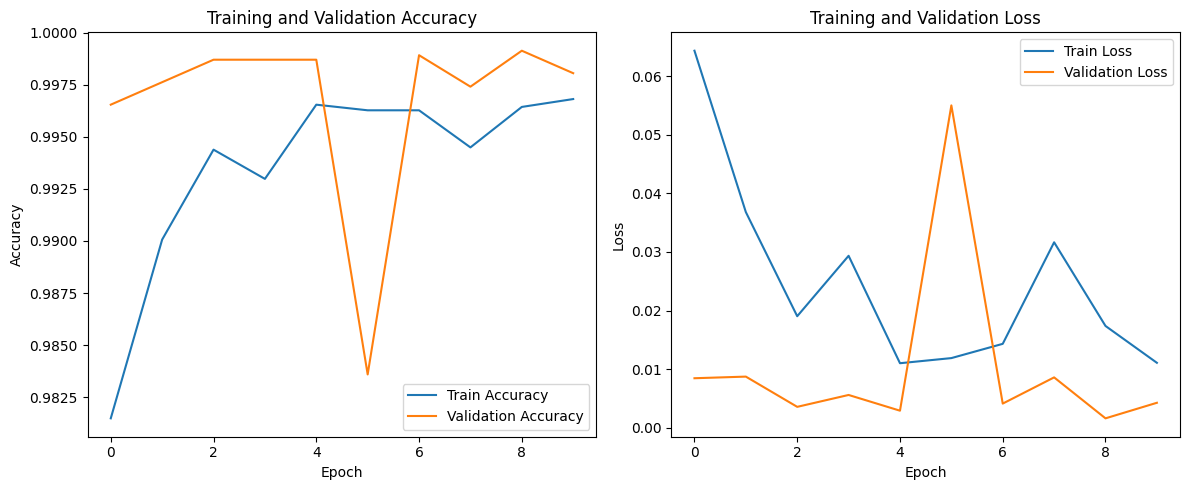

In [ ]:
# Plot training and validation accuracy and loss

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


905/905 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
True label distribution: {np.str_('Closed Fist'): np.int64(9648), np.str_('Wrist Extension'): np.int64(9650), np.str_('Wrist Flexion'): np.int64(9647)}
Predicted label distribution: {np.str_('Closed Fist'): np.int64(9641), np.str_('Wrist Extension'): np.int64(9657), np.str_('Wrist Flexion'): np.int64(9647)}


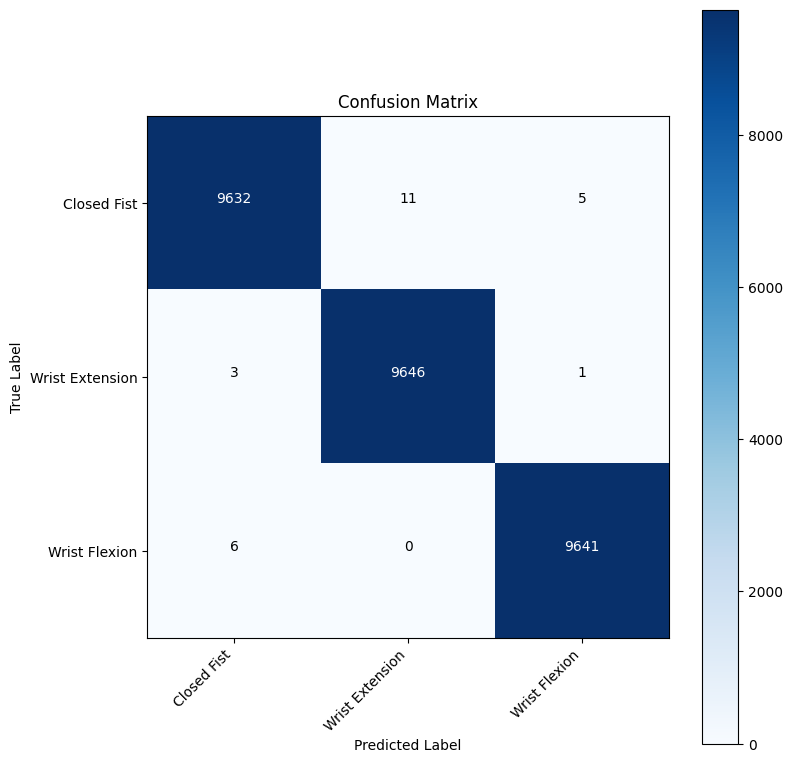

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

# Option 2: Evaluate on the entire dataset
X_eval, y_eval = X, y_categorical


# Predict probabilities and then convert to class labels
y_pred_probs = model.predict(X_eval)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_eval, axis=1)

# Print distributions for debugging
unique_true, counts_true = np.unique(y_true, return_counts=True)
unique_pred, counts_pred = np.unique(y_pred, return_counts=True)
print("True label distribution:", dict(zip(le.classes_, counts_true)))
print("Predicted label distribution:", dict(zip(le.classes_, counts_pred)))

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()

# Use the original class names from the label encoder
classes = le.classes_
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45, ha="right")
plt.yticks(tick_marks, classes)

# Add counts in each cell
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], "d"),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()
